In [93]:
# Import of libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

Paper: The data used was retrieved from Yahoo Finance[16], on a period of 17 years of the S&P 500 stock price data, ranging from January 2001 to December 2018. 

In [51]:
start_date = '2001-01-01'
end_date = '2018-12-31'

In [52]:
sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')

[*********************100%***********************]  1 of 1 completed


In [53]:
sp500.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000
2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000
2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000
2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000
2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000


In [54]:
sp500.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [55]:
# Flatten the MultiIndex columns into  a single level
sp500.columns = ['_'.join(col).strip() for col in sp500.columns.values]

In [56]:
sp500.head()

,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC
Date,,,,,
2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000
2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000
2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000
2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000
2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000


In [57]:
sp500.columns

Index(['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC'], dtype='object')

In [58]:
# Reset the index  to default
sp500 = sp500.reset_index()

# Conver 'Date' column to datetime format
sp500['Date']=pd.to_datetime(sp500['Date'])

In [59]:
sp500.head()

,Date,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000


In [60]:
sp500.columns = ['Date'] + [col.split('_')[0] for col in sp500.columns[1:]]

In [61]:
sp500.tail()

,Date,Close,High,Low,Open,Volume
211,2018-08-01,2901.520020,2916.500000,2796.340088,2821.169922,69523070000
212,2018-09-01,2913.979980,2940.909912,2864.120117,2896.959961,63031510000
213,2018-10-01,2711.739990,2939.860107,2603.540039,2926.290039,91930980000
214,2018-11-01,2760.169922,2815.149902,2631.090088,2717.580078,80620020000
215,2018-12-01,2506.850098,2800.179932,2346.580078,2790.500000,84162180000


Paper: "There is a total of 216 monthly observations. "

In [62]:
sp500.shape

(216, 6)

We see that we have 216 month in our dataset, which is alligned with the provided data in the paper.

In [63]:
# Difference of order 1
sp500['close_diff'] = sp500['Close'].diff()

In [64]:
sp500.head()

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985


In [65]:
train = sp500.loc[:'2017-12-31']
test = sp500.loc['2018-01-01':]

In [66]:
train

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
197,2017-06-01,2423.409912,2453.820068,2405.699951,2415.649902,81078810000,11.609863
198,2017-07-01,2470.300049,2484.040039,2407.699951,2431.389893,63348090000,46.890137
199,2017-08-01,2471.649902,2490.870117,2417.350098,2477.100098,70784900000,1.349854
200,2017-09-01,2519.360107,2519.439941,2446.550049,2474.419922,66624120000,47.710205


In [67]:
test

,Date,Close,High,Low,Open,Volume,close_diff
202,2017-11-01,2647.580078,2657.739990,2557.449951,2583.209961,73416960000,72.320068
203,2017-12-01,2673.610107,2694.969971,2605.520020,2645.100098,65531700000,26.030029
204,2018-01-01,2823.810059,2872.870117,2682.360107,2683.729980,77318690000,150.199951
205,2018-02-01,2713.830078,2835.959961,2532.689941,2816.449951,79933970000,-109.979980
206,2018-03-01,2640.870117,2801.899902,2585.889893,2715.219971,76803890000,-72.959961
207,2018-04-01,2648.050049,2717.489990,2553.800049,2633.449951,70194700000,7.179932
208,2018-05-01,2705.270020,2742.239990,2594.620117,2642.959961,76011820000,57.219971
209,2018-06-01,2718.370117,2791.469971,2691.989990,2718.699951,77891360000,13.100098
210,2018-07-01,2816.290039,2848.030029,2698.949951,2704.949951,64898300000,97.919922
211,2018-08-01,2901.520020,2916.500000,2796.340088,2821.169922,69523070000,85.229980


In [68]:
train.shape

(202, 7)

In [69]:
test.shape

(14, 7)

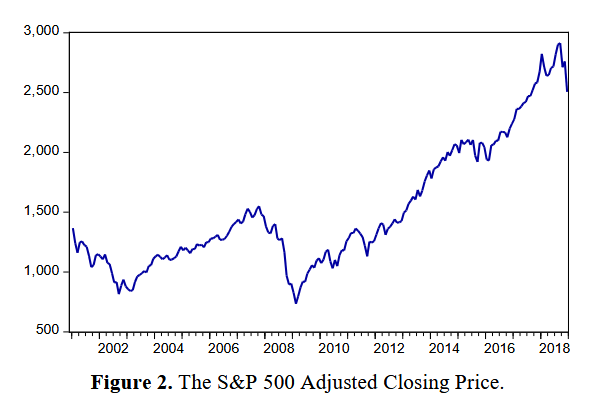

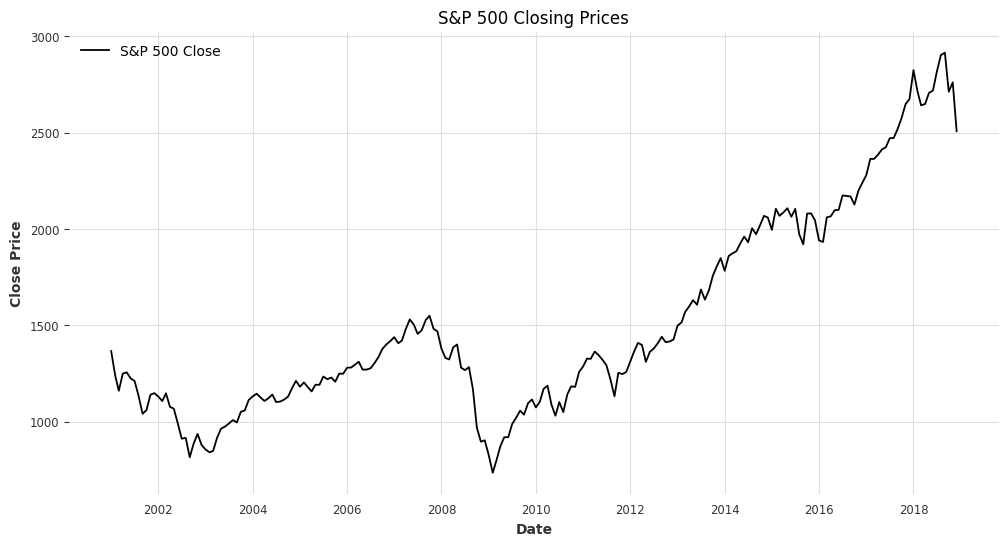

In [70]:
plt.figure(figsize=(12, 6))  
plt.plot(sp500['Date'], sp500['Close'], label='S&P 500 Close')  # Plot Date vs Close
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('S&P 500 Closing Prices')
plt.legend()
plt.show()

In terms of graphs we see that they plotted the whole df - sp500; not split train and test

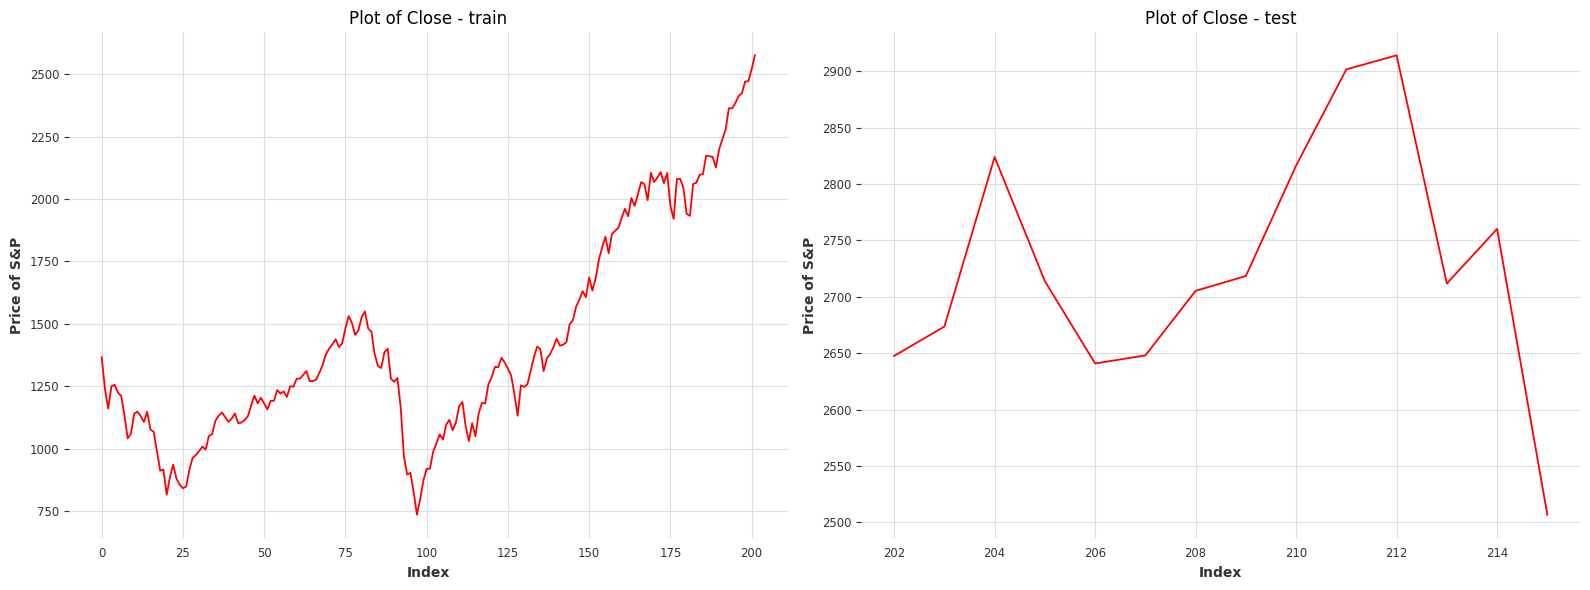

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot train close prices on the left subplot
axs[0].plot(train['Close'], color='red')
axs[0].set_title('Plot of Close - train')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Price of S&P')
axs[0].grid(True)

# Plot test close prices on the right subplot
axs[1].plot(test['Close'], color='red')
axs[1].set_title('Plot of Close - test')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Price of S&P')
axs[1].grid(True)

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

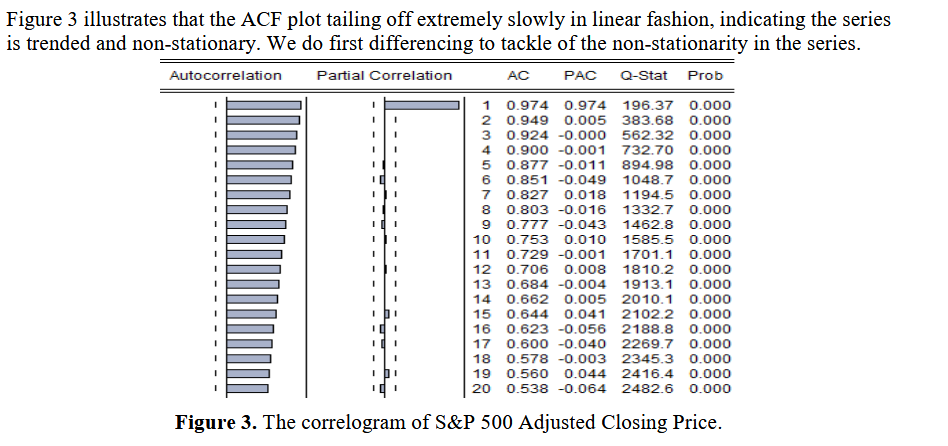

It is not defined they test ACF/PACF for the whole dataframa or only train; so we decided to test ACF/PACF/AC/PAC/Q-stat/Prob for full dataframe/train; no need for test since we have only 14 observations

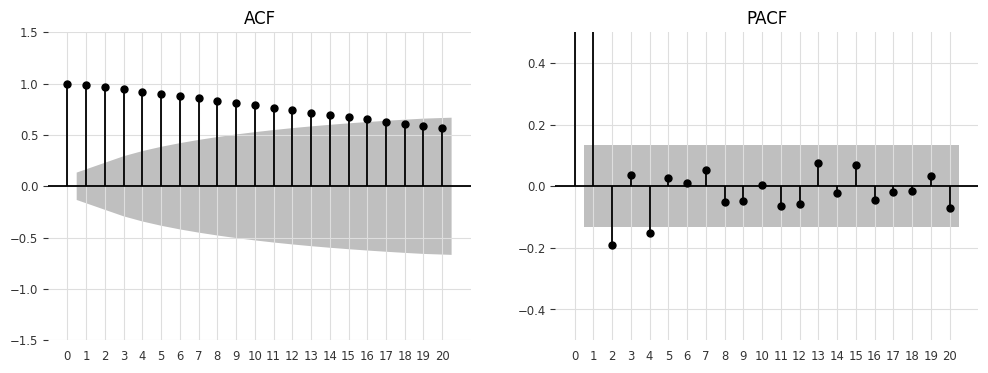

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(sp500['Close'], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-1.5,1.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(sp500['Close'], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

In [73]:
# Calculate numerical ACF/PACF values
acf_values_sp500, acf_confint_sp500 = acf(sp500['Close'], nlags=20, alpha=0.05)
pacf_values_sp500, pacf_confint_sp500 = pacf(sp500['Close'], nlags=20, alpha=0.05)

# Ljung-Box Q-test
q_test_sp500 = acorr_ljungbox(sp500['Close'], lags=20, return_df=True) 

# Create EViews-style summary table
results_sp500 = pd.DataFrame({
    'Lag': range(1, 21),
    'AC': acf_values_sp500[1:],  # Exclude lag-0
    'PAC': pacf_values_sp500[1:],
    'Q-Stat': q_test_sp500['lb_stat'].values,
    'Prob': q_test_sp500['lb_pvalue'].values
})

print("\nAutocorrelation Summary:")
print(results_sp500.round(4))


Autocorrelation Summary:
    Lag      AC     PAC     Q-Stat  Prob
0     1  0.9854  0.9900   212.6577   0.0
1     2  0.9654 -0.2809   417.7318   0.0
2     3  0.9458  0.0852   615.4782   0.0
3     4  0.9225 -0.2491   804.5125   0.0
4     5  0.8989  0.1037   984.8270   0.0
5     6  0.8763 -0.0254  1157.0137   0.0
6     7  0.8553  0.1209  1321.8419   0.0
7     8  0.8339 -0.1322  1479.2653   0.0
8     9  0.8112 -0.0286  1628.9594   0.0
9    10  0.7891 -0.0154  1771.2767   0.0
10   11  0.7656 -0.0869  1905.9074   0.0
11   12  0.7399 -0.0651  2032.2869   0.0
12   13  0.7163  0.1432  2151.3079   0.0
13   14  0.6933 -0.0806  2263.3541   0.0
14   15  0.6720  0.1797  2369.1463   0.0
15   16  0.6513 -0.1834  2469.0088   0.0
16   17  0.6303  0.0769  2563.0180   0.0
17   18  0.6099 -0.1323  2651.4687   0.0
18   19  0.5902  0.1928  2734.7328   0.0
19   20  0.5692 -0.2900  2812.5642   0.0


So we see that values from the paper and here are not aligned, so we need to test train/test

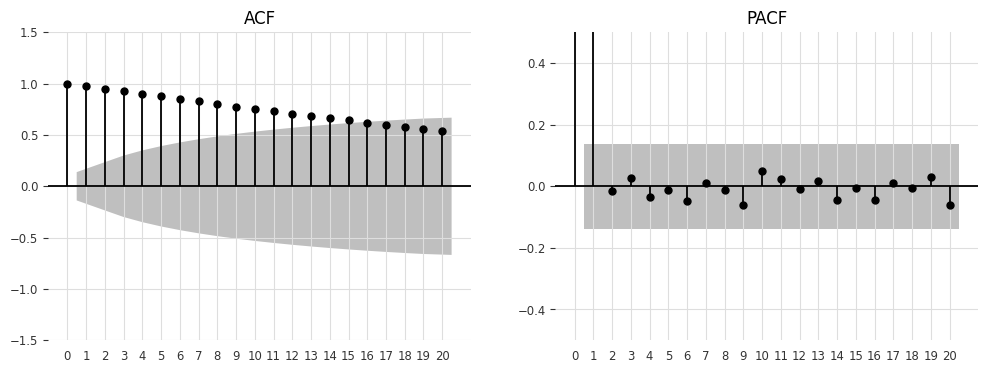

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(train['Close'], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-1.5,1.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(train['Close'], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

In [75]:
# Calculate numerical ACF/PACF values
acf_values_train, acf_confint_train = acf(train['Close'], nlags=20, alpha=0.05)
pacf_values_train, pacf_confint_train = pacf(train['Close'], nlags=20, alpha=0.05)

# Ljung-Box Q-test
q_test_train = acorr_ljungbox(train['Close'], lags=20, return_df=True) 

# Create EViews-style summary table
results_train = pd.DataFrame({
    'Lag': range(1, 21),
    'AC': acf_values_train[1:],  # Exclude lag-0
    'PAC': pacf_values_train[1:],
    'Q-Stat': q_test_train['lb_stat'].values,
    'Prob': q_test_train['lb_pvalue'].values
})

print("\nAutocorrelation Summary:")
print(results_train.round(4))


Autocorrelation Summary:
    Lag      AC     PAC     Q-Stat  Prob
0     1  0.9749  0.9797   194.8331   0.0
1     2  0.9496 -0.0188   380.6137   0.0
2     3  0.9263  0.0346   558.2774   0.0
3     4  0.9019 -0.0425   727.5654   0.0
4     5  0.8775 -0.0148   888.6153   0.0
5     6  0.8514 -0.0600  1041.0184   0.0
6     7  0.8265  0.0144  1185.3841   0.0
7     8  0.8019 -0.0157  1321.9685   0.0
8     9  0.7747 -0.0771  1450.1231   0.0
9    10  0.7508  0.0665  1571.1219   0.0
10   11  0.7290  0.0316  1685.7818   0.0
11   12  0.7070 -0.0114  1794.2029   0.0
12   13  0.6864  0.0218  1896.9420   0.0
13   14  0.6642 -0.0577  1993.6548   0.0
14   15  0.6426 -0.0094  2084.6432   0.0
15   16  0.6196 -0.0595  2169.6994   0.0
16   17  0.5976  0.0186  2249.2446   0.0
17   18  0.5766 -0.0084  2323.6929   0.0
18   19  0.5574  0.0442  2393.6446   0.0
19   20  0.5357 -0.0828  2458.6099   0.0


Here we see that results are similar, but there is still some rounding or precision 

In [76]:
sp500

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
211,2018-08-01,2901.520020,2916.500000,2796.340088,2821.169922,69523070000,85.229980
212,2018-09-01,2913.979980,2940.909912,2864.120117,2896.959961,63031510000,12.459961
213,2018-10-01,2711.739990,2939.860107,2603.540039,2926.290039,91930980000,-202.239990
214,2018-11-01,2760.169922,2815.149902,2631.090088,2717.580078,80620020000,48.429932


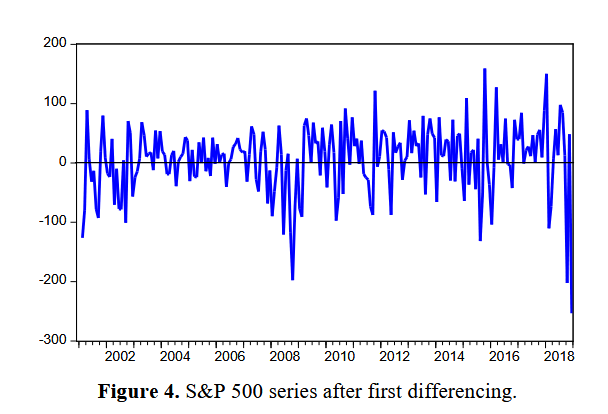

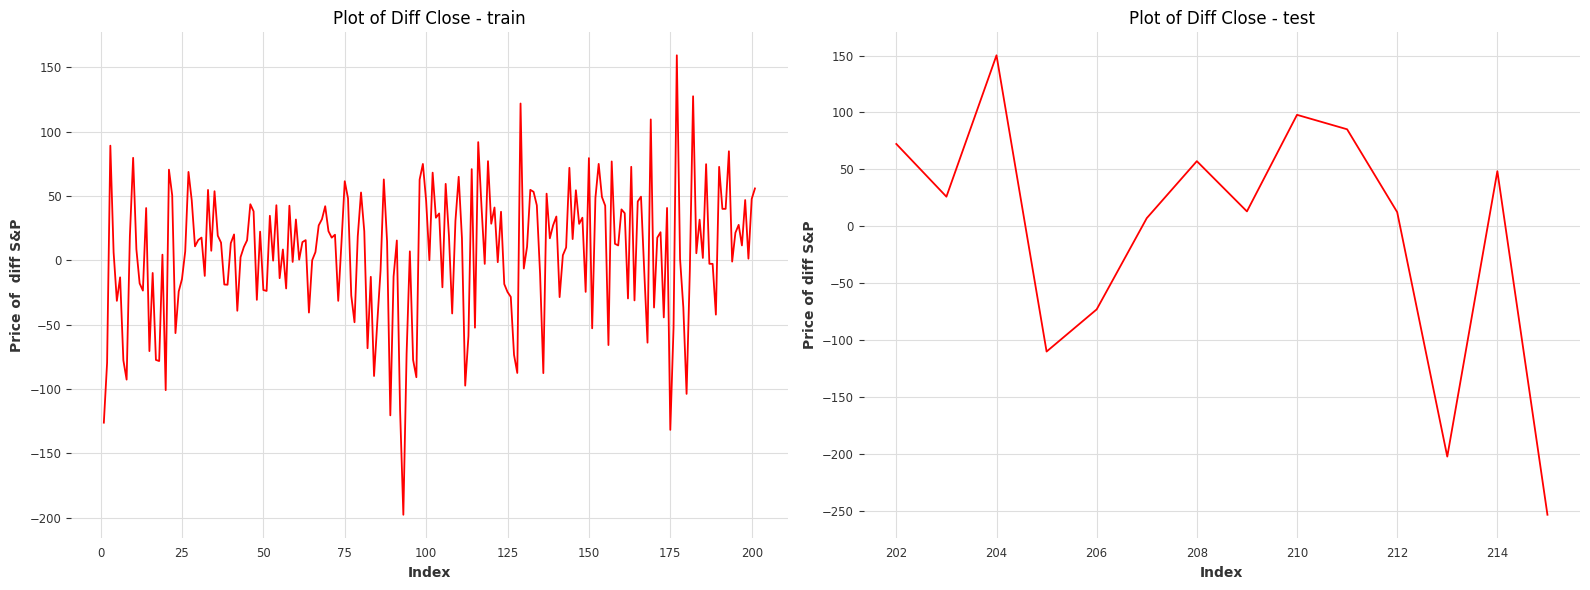

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot train difference of close prices on the left subplot
axs[0].plot(train['close_diff'], color='red')
axs[0].set_title('Plot of Diff Close - train')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Price of  diff S&P')
axs[0].grid(True)

# Plot test difference of close prices on the right subplot
axs[1].plot(test['close_diff'], color='red')
axs[1].set_title('Plot of Diff Close - test')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Price of diff S&P')
axs[1].grid(True)

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

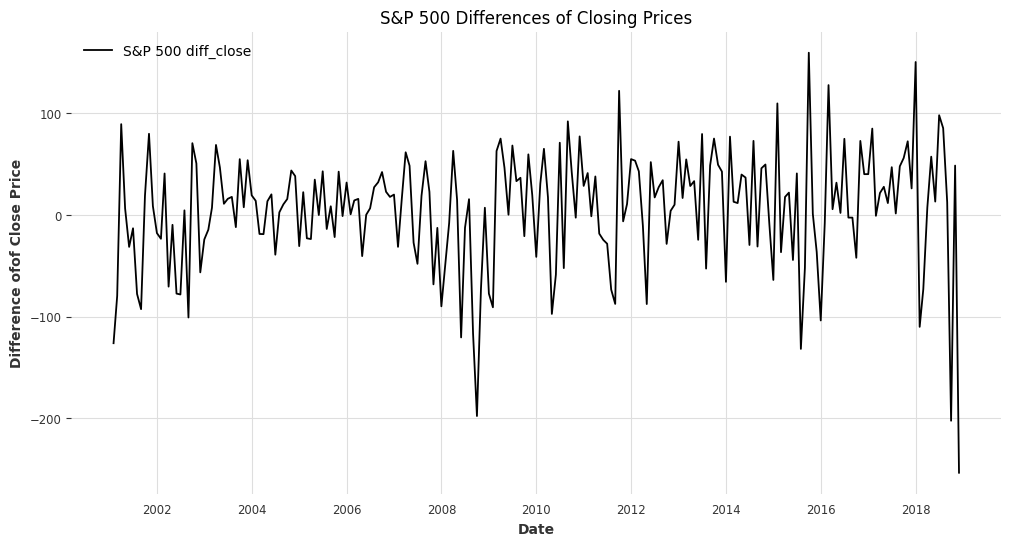

In [78]:
plt.figure(figsize=(12, 6))  
plt.plot(sp500['Date'], sp500['close_diff'], label='S&P 500 diff_close')  # Plot Date vs Close
plt.xlabel('Date')
plt.ylabel('Difference ofof Close Price')
plt.title('S&P 500 Differences of Closing Prices')
plt.legend()
plt.show()

In [79]:
train

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
197,2017-06-01,2423.409912,2453.820068,2405.699951,2415.649902,81078810000,11.609863
198,2017-07-01,2470.300049,2484.040039,2407.699951,2431.389893,63348090000,46.890137
199,2017-08-01,2471.649902,2490.870117,2417.350098,2477.100098,70784900000,1.349854
200,2017-09-01,2519.360107,2519.439941,2446.550049,2474.419922,66624120000,47.710205


In [80]:
def adf_test(series, title=''):
    """Perform ADF test with trend and intercept"""
    result = adfuller(series, regression='ct', autolag='AIC')
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }
    return output


In [81]:

# Run tests
level = adf_test(sp500['Close'], "Level")
diff = adf_test(pd.Series(sp500['close_diff']).dropna(), "First Difference")

# Create results table
results = pd.DataFrame({
    'Model': ['Trend and intercept', 'Trend and intercept'],
    'Data': ['Level', 'First difference'],
    'Test Statistic': [level['Test Statistic'], diff['Test Statistic']],
    'Probability': [level['p-value'], diff['p-value']]
})

# Format output
print("Table 1. Augmented Dickey-Fuller Test\n")
print(results.to_string(float_format=lambda x: f"{x:.5f}", index=False))

# Add critical values
print("\nCritical Values:")
for key in level['Critical Values']:
    print(f"{key}%: {level['Critical Values'][key]:.5f}")

Table 1. Augmented Dickey-Fuller Test

              Model             Data  Test Statistic  Probability
Trend and intercept            Level        -2.16731      0.50826
Trend and intercept First difference       -13.25297      0.00000

Critical Values:
1%%: -4.00151
5%%: -3.43111
10%%: -3.13916


In [82]:
# Run tests
level = adf_test(train['Close'], "Level")
diff = adf_test(pd.Series(train['close_diff']).dropna(), "First Difference")

# Create results table
results = pd.DataFrame({
    'Model': ['Trend and intercept', 'Trend and intercept'],
    'Data': ['Level', 'First difference'],
    'Test Statistic': [level['Test Statistic'], diff['Test Statistic']],
    'Probability': [level['p-value'], diff['p-value']]
})

# Format output
print("Table 1. Augmented Dickey-Fuller Test\n")
print(results.to_string(float_format=lambda x: f"{x:.5f}", index=False))

# Add critical values
print("\nCritical Values:")
for key in level['Critical Values']:
    print(f"{key}%: {level['Critical Values'][key]:.5f}")

Table 1. Augmented Dickey-Fuller Test

              Model             Data  Test Statistic  Probability
Trend and intercept            Level        -1.42949      0.85205
Trend and intercept First difference       -13.20496      0.00000

Critical Values:
1%%: -4.00453
5%%: -3.43256
10%%: -3.14001


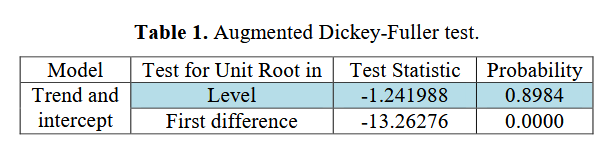

Possible challenge: such small difference from the work can be from the problem that it is not stated when differences where calculated, since in our approach we calculated them

In [83]:
train

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
197,2017-06-01,2423.409912,2453.820068,2405.699951,2415.649902,81078810000,11.609863
198,2017-07-01,2470.300049,2484.040039,2407.699951,2431.389893,63348090000,46.890137
199,2017-08-01,2471.649902,2490.870117,2417.350098,2477.100098,70784900000,1.349854
200,2017-09-01,2519.360107,2519.439941,2446.550049,2474.419922,66624120000,47.710205


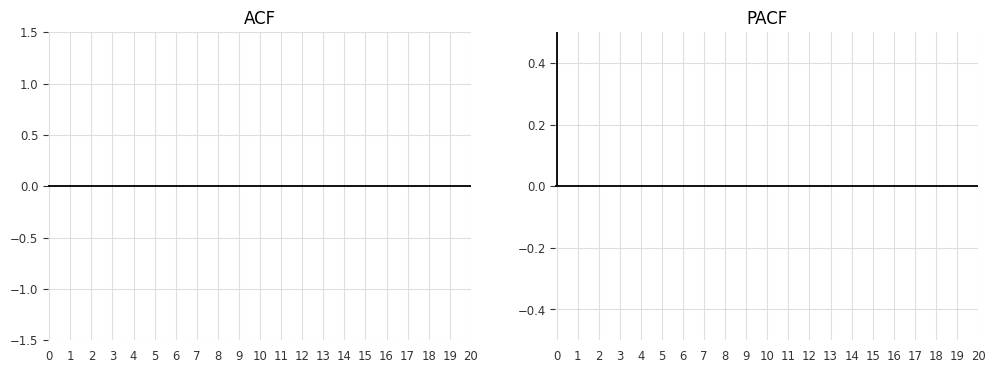

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(train['Close'].diff(), lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-1.5,1.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(train['Close'].diff(), lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

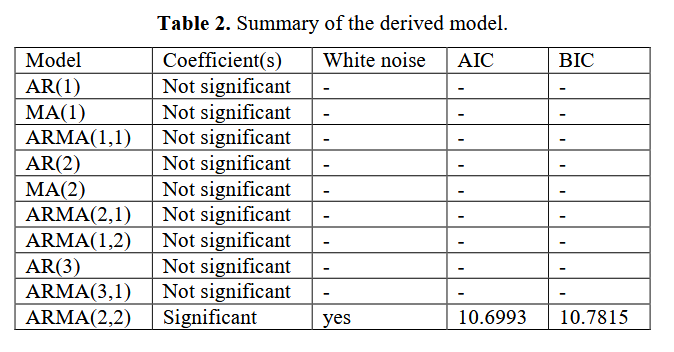

In [49]:
train

,Date,Close,High,Low,Open,Volume,close_diff
time,,,,,,,
0,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
1,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
2,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
3,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
4,2001-06-01,1224.380005,1286.619995,1203.030029,1255.819946,24748030000,-31.439941
...,...,...,...,...,...,...,...
196,2017-06-01,2423.409912,2453.820068,2405.699951,2415.649902,81078810000,11.609863
197,2017-07-01,2470.300049,2484.040039,2407.699951,2431.389893,63348090000,46.890137
198,2017-08-01,2471.649902,2490.870117,2417.350098,2477.100098,70784900000,1.349854


In [86]:
train

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
197,2017-06-01,2423.409912,2453.820068,2405.699951,2415.649902,81078810000,11.609863
198,2017-07-01,2470.300049,2484.040039,2407.699951,2431.389893,63348090000,46.890137
199,2017-08-01,2471.649902,2490.870117,2417.350098,2477.100098,70784900000,1.349854
200,2017-09-01,2519.360107,2519.439941,2446.550049,2474.419922,66624120000,47.710205


In [108]:
ar1 = ARIMA(train['Close'].values, order=(1, 1, 0)).fit()
ma1 = ARIMA(train['Close'].values, order=(0, 1, 1)).fit()
arma11 = ARIMA(train['Close'].values, order=(1, 1, 1)).fit()
ar2 = ARIMA(train['Close'].values, order=(2, 1, 0)).fit()
ma2 = ARIMA(train['Close'].values, order=(0, 1, 2)).fit()
arma21 = ARIMA(train['Close'].values, order=(2, 1, 1)).fit()
arma12 = ARIMA(train['Close'].values, order=(1, 1, 2)).fit()
ar3 = ARIMA(train['Close'].values, order=(3, 1, 0)).fit()
arma31 = ARIMA(train['Close'].values, order=(3, 1, 1)).fit()
arma22 = ARIMA(train['Close'].values, order=(2, 1, 2)).fit()


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [120]:
models = [ar1, ma1, arma11, ar2, ma2, arma21, arma12, ar3, arma31, arma22] # list with all the models
names = ['ar1', 'ma1', 'arma11','ar2', 'ma2', 'arma21', 'arma12', 'ar3', 'arma31', 'arma22'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

print('Models by AIC:\n',results_df.sort_values('AIC'))
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by AIC:
     model      AIC      BIC
9  arma22  2164.14  2180.65
1     ma1  2165.87  2172.47
0     ar1  2166.21  2172.81
2  arma11  2166.57  2176.48
8  arma31  2166.58  2183.10
4     ma2  2167.19  2177.10
3     ar2  2167.58  2177.49
7     ar3  2167.68  2180.89
5  arma21  2168.57  2181.79
6  arma12  2168.57  2181.79
Models by BIC:
     model      AIC      BIC
1     ma1  2165.87  2172.47
0     ar1  2166.21  2172.81
2  arma11  2166.57  2176.48
4     ma2  2167.19  2177.10
3     ar2  2167.58  2177.49
9  arma22  2164.14  2180.65
7     ar3  2167.68  2180.89
5  arma21  2168.57  2181.79
6  arma12  2168.57  2181.79
8  arma31  2166.58  2183.10


In [119]:
print(arma22.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  202
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1077.068
Date:                Tue, 13 May 2025   AIC                           2164.135
Time:                        22:18:01   BIC                           2180.652
Sample:                             0   HQIC                          2170.819
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0142      0.107      0.132      0.895      -0.196       0.224
ar.L2          0.8559      0.092      9.296      0.000       0.675       1.036
ma.L1          0.1188      0.859      0.138      0.8

In [94]:
def calculate_information_criteria(model_fit, method='ARMA'):
    """
    Calculate AIC and BIC manually for fitted ARIMA/ARMA models
    
    Parameters:
    model_fit : fitted model object
    method : 'ARMA' or 'ARIMA' (affects parameter count)
    
    Returns:
    aic, bic : calculated values
    """
    
    # Get log-likelihood
    llf = model_fit.llf
    
    # Count number of parameters
    if method == 'ARMA':
        # ARMA(p,q) has p + q + 1 parameters (AR + MA + variance)
        n_params = len(model_fit.arparams) + len(model_fit.maparams) + 1
    else:
        # ARIMA(p,d,q) has p + q + 1 parameters
        n_params = model_fit.k_params - 1  # exclude sigma2
    
    # Number of observations used in estimation
    nobs = model_fit.nobs
    
    # Calculate AIC and BIC
    aic = -2 * llf + 2 * n_params
    bic = -2 * llf + np.log(nobs) * n_params
    
    return aic, bic

In [95]:
manual_aic, manual_bic = calculate_information_criteria(arma22, method='ARMA')

In [97]:
train.to_csv('train.csv', index=False)


In [96]:
print(f"Manually Calculated:")
print(f"AIC: {manual_aic:.2f}")
print(f"BIC: {manual_bic:.2f}")
print(f"\nModel Reported:")
print(f"AIC: {arma22.aic:.2f}")
print(f"BIC: {arma22.bic:.2f}")

Manually Calculated:
AIC: 2176.65
BIC: 2193.19

Model Reported:
AIC: 2176.65
BIC: 2193.16


In [42]:
from statsmodels.tsa.arima.model import ARIMA
import time

# Fit model
start_time = time.time()
model_sm = ARIMA(train['close_diff'], order=(2,1,2))
result_sm = model_sm.fit()
sm_time = time.time() - start_time

print("statsmodels ARIMA(2,1,2):")
print(f"Fit time: {sm_time:.3f}s")
print(f"AIC: {result_sm.aic:.2f}, BIC: {result_sm.bic:.2f}")
print(result_sm.summary())

statsmodels ARIMA(2,1,2):
Fit time: 0.282s
AIC: 2160.97, BIC: 2177.46
                               SARIMAX Results                                
Dep. Variable:             close_diff   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1075.486
Date:                Tue, 13 May 2025   AIC                           2160.972
Time:                        20:20:48   BIC                           2177.463
Sample:                             0   HQIC                          2167.645
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4638      0.462     -1.004      0.315      -1.370       0.442
ar.L2         -0.0519      0.087     -0.598      0.550      -

In [43]:
from pmdarima import ARIMA as pmdARIMA

start_time = time.time()
model_pmd = pmdARIMA(order=(2,1,2), suppress_warnings=True)
result_pmd = model_pmd.fit(train['close_diff'])
pmd_time = time.time() - start_time

print("\npmdarima ARIMA(2,1,2):")
print(f"Fit time: {pmd_time:.3f}s")
print(f"AIC: {result_pmd.aic():.2f}, BIC: {result_pmd.bic():.2f}")
print(result_pmd.summary())

C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



pmdarima ARIMA(2,1,2):
Fit time: 0.428s
AIC: 2155.95, BIC: 2175.74
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1071.974
Date:                Tue, 13 May 2025   AIC                           2155.948
Time:                        20:21:01   BIC                           2175.738
Sample:                             0   HQIC                          2163.956
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3005      0.125      2.409      0.016       0.056       0.545
ar.L1         -0.8800      0.072    -12.145      0.000      -1.

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

start_time = time.time()
model_sx = SARIMAX(train['close_diff'], order=(2,1,2))
result_sx = model_sx.fit(disp=False)
sx_time = time.time() - start_time

print("\nSARIMAX ARIMA(2,1,2):")
print(f"Fit time: {sx_time:.3f}s")
print(f"AIC: {result_sx.aic:.2f}, BIC: {result_sx.bic:.2f}")
print(result_sx.summary())


SARIMAX ARIMA(2,1,2):
Fit time: 0.170s
AIC: 2160.97, BIC: 2177.46
                               SARIMAX Results                                
Dep. Variable:             close_diff   No. Observations:                  201
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1075.486
Date:                Tue, 13 May 2025   AIC                           2160.972
Time:                        20:21:01   BIC                           2177.463
Sample:                             0   HQIC                          2167.645
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4638      0.462     -1.004      0.315      -1.370       0.442
ar.L2         -0.0519      0.087     -0.598      0.550      -0.2

In [45]:
from darts.models import ARIMA as dartsARIMA
from darts import TimeSeries

darts_series = TimeSeries.from_series(train['close_diff'])

start_time = time.time()
model_darts = dartsARIMA(p=2, d=1, q=2)
model_darts.fit(darts_series)
darts_time = time.time() - start_time

print("\nDarts ARIMA(2,1,2):")
print(f"Fit time: {darts_time:.3f}s")
# Note: Darts doesn't provide AIC/BIC directly

C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Darts ARIMA(2,1,2):
Fit time: 0.305s


In [46]:
results = pd.DataFrame({
    'Package': ['statsmodels', 'pmdarima', 'SARIMAX', 'Darts'],
    'Fit Time (s)': [sm_time, pmd_time, sx_time, darts_time],
    'AIC': [result_sm.aic, result_pmd.aic(), result_sx.aic, None],
    'BIC': [result_sm.bic, result_pmd.bic(), result_sx.bic, None],
    'Converged': [result_sm.mle_retvals['converged'], 
                 result_pmd.model_.converged_,
                 result_sx.mle_retvals['converged'],
                 True]  # Darts doesn't report
})

print("\nComparison of ARIMA(2,1,2) Implementations:")
print(results.to_string(index=False))

AttributeError: 'ARIMA' object has no attribute 'model_'